In [ ]:
#步骤 1：选择要分析的资产类别
#选择3-5种不同类型的资产（如股票、债券或ETF），可以考虑具有一定关联性或代表性的资产。例如：
#股票：选择知名公司的股票，如苹果 (AAPL)、微软 (MSFT)。

#债券：可以选择美国国债ETF，如TLT（20+年期美国国债ETF）。

#ETF或指数：如标普500指数ETF (SPY)。

#记下每种资产的股票代码，方便后续查询。

In [2]:
!pip install yfinance


In [4]:
#步骤 2：使用yfinance获取数据
import yfinance as yf
import pandas as pd

# 定义资产代码和数据拉取时间范围
tickers = ["AAPL", "MSFT", "TLT", "SPY"]  # 你选择的资产代码
start_date = "2022-01-01"  # 开始日期
end_date = "2023-12-31"    # 结束日期

# 使用 yf.download 拉取数据
data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

# 查看数据格式
print(data.head())


[*********************100%***********************]  4 of 4 completed

Ticker                           AAPL        MSFT         SPY         TLT
Date                                                                     
2022-01-03 00:00:00+00:00  179.076599  326.940826  458.720306  132.262466
2022-01-04 00:00:00+00:00  176.803848  321.334747  458.566650  131.712509
2022-01-05 00:00:00+00:00  172.100861  308.999390  449.761169  130.997574
2022-01-06 00:00:00+00:00  169.227936  306.557739  449.338684  131.336685
2022-01-07 00:00:00+00:00  169.395187  306.713959  447.562195  130.392639


In [8]:
data.to_csv("C:/Users/12/Desktop/financial_data.csv")


In [29]:
# 检查缺失值
print(data.isnull().sum())

# 使用前向填充填补缺失值
data.ffill(inplace=True)


Ticker
AAPL    0
MSFT    0
SPY     0
TLT     0
dtype: int64


In [11]:
#设置日期索引
data = data.sort_index()


In [30]:

import numpy as np
#计算每日收益率
returns = data.pct_change().dropna()
log_returns = np.log(1 + returns)


In [31]:
#检查数据格式
print(log_returns.head())


Ticker                         AAPL      MSFT       SPY       TLT
Date                                                             
2022-01-04 00:00:00+00:00 -0.012773 -0.017296 -0.000335 -0.004167
2022-01-05 00:00:00+00:00 -0.026960 -0.039144 -0.019389 -0.005443
2022-01-06 00:00:00+00:00 -0.016834 -0.007933 -0.000940  0.002585
2022-01-07 00:00:00+00:00  0.000988  0.000509 -0.003961 -0.007214
2022-01-10 00:00:00+00:00  0.000116  0.000732 -0.001245  0.002457


In [32]:
#保存
log_returns.to_csv("C:/Users/12/Desktop/financial_data_log.csv")


In [ ]:
#Day 2
#目标：
#计算不同资产的VaR（Value at Risk，价值风险）。
#使用历史模拟法和方差-协方差法两种常见方法。

In [17]:
# 设置置信水平
confidence_level = 0.95  # 或 0.99

# 计算VaR，按置信水平选取对应的分位数
VaR_historical = returns.quantile(1 - confidence_level)

print(f"历史模拟法计算的VaR（{int(confidence_level*100)}%置信水平）: {VaR_historical}")
#我们通过历史数据的分位数来计算VaR。例如，若95%置信水平下，历史收益率的第5%分位数即为VaR。

历史模拟法计算的VaR（95%置信水平）: Ticker
AAPL   -0.030060
MSFT   -0.030912
SPY    -0.019635
TLT    -0.019787
Name: 0.050000000000000044, dtype: float64


In [18]:
# 计算均值和标准差
mean_return = returns.mean()
std_dev = returns.std()

# 根据正态分布计算VaR（95%置信水平）
VaR_variance_cov = mean_return - (std_dev * 1.645)  # 1.645是95%置信水平对应的z分数

print(f"方差-协方差法计算的VaR（{int(confidence_level*100)}%置信水平）: {VaR_variance_cov}")


方差-协方差法计算的VaR（95%置信水平）: Ticker
AAPL   -0.029827
MSFT   -0.031384
SPY    -0.020107
TLT    -0.020639
dtype: float64


In [20]:
# 创建一个VaR结果数据框，进行比较
VaR_results = pd.DataFrame({
    'VaR_Historical': VaR_historical,
    'VaR_Variance_Covariance': VaR_variance_cov
})

# 保存VaR结果
VaR_results.to_csv("C:/Users/12/Desktop/financial_data_VaR.csv")

# 输出VaR结果
print(VaR_results)


        VaR_Historical  VaR_Variance_Covariance
Ticker                                         
AAPL         -0.030060                -0.029827
MSFT         -0.030912                -0.031384
SPY          -0.019635                -0.020107
TLT          -0.019787                -0.020639


In [ ]:
#Day3
#实现ES（期望损失）计算
#目标：
#计算不同资产在指定置信水平下的ES（Expected Shortfall，期望损失）。
#ES是VaR的延伸，用于衡量当市场出现极端负面波动时的潜在损失。
#ES（期望损失）通常定义为在VaR临界点下，损失超过VaR的平均值。
#计算方法：
#首先计算VaR。
#然后，计算所有超过VaR的损失的平均值。

In [21]:
# 已经计算了方差-协方差法的VaR（95%置信水平）
# `returns` 是你的每日收益率数据，`VaR_variance_cov` 是方差-协方差法计算的VaR

# 筛选出超出VaR的收益率数据（即负损失）
losses_above_VaR_cov = returns[returns <= VaR_variance_cov]

# 计算超出VaR的损失的平均值（期望损失）
ES_variance_cov = losses_above_VaR_cov.mean()

# 输出期望损失（ES）
print(f"方差-协方差法计算的期望损失（ES）为: {ES_variance_cov}")


方差-协方差法计算的期望损失（ES）为: Ticker
AAPL   -0.039955
MSFT   -0.041576
SPY    -0.028684
TLT    -0.024945
dtype: float64


In [25]:
# 【优化】输出期望损失（ES），转换为百分比
ES_percentage = ES_variance_cov * 100  # 转换为百分比

# 输出每个资产的期望损失（ES）并显示为百分比
print(f"方差-协方差法计算的期望损失（ES）%为：")
print(ES_percentage)


方差-协方差法计算的期望损失（ES）%为：
Ticker
AAPL   -3.995491
MSFT   -4.157581
SPY    -2.868412
TLT    -2.494512
dtype: float64


In [ ]:
#结果解释
AAPL: -3.9955% 表示，如果发生极端亏损，AAPL的期望损失为3.9955%。
MSFT: -4.1576% 表示，MSFT的期望损失为4.1576%。
SPY: -2.8684% 表示，SPY的期望损失为2.8684%。
TLT: -2.4945% 表示，TLT的期望损失为2.4945%。

#思考
进一步的思考：
对比VaR和ES：
你可以比较VaR和ES的计算结果，发现ES比VaR更能反映出当损失发生时，投资者可能面临的更大损失。
多种资产的风险组合：
如果你有多个资产组合，ES可以帮助你了解组合中最大损失的可能性，帮助你优化组合的风险暴露。

In [ ]:
#步骤 1：计算投资组合的VaR和ES
#目标：如果你已经在单一资产上完成了VaR和ES的计算，那么下一步就是对投资组合进行风险评估。你将基于单个资产的VaR和ES，计算整个投资组合的VaR和ES。
假设你有一个包含不同资产的投资组合（例如：AAPL、MSFT、SPY、TLT），每个资产有一个特定的权重。你将使用资产的协方差矩阵来计算整个投资组合的VaR和ES。
投资组合的VaR：
计算每个资产的协方差矩阵。
计算投资组合的标准差。
使用投资组合标准差计算VaR。

In [26]:
# 假设你已经有了收益率数据 `returns`
# 计算资产的协方差矩阵
cov_matrix = returns.cov()

# 假设你有一个投资组合权重的向量
weights = np.array([0.25, 0.25, 0.25, 0.25])  # 假设每个资产的权重为25%

# 计算投资组合的标准差
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_std_dev = np.sqrt(portfolio_variance)

# 计算投资组合的VaR（95%置信水平）
VaR_portfolio = portfolio_std_dev * 1.645  # 95%置信水平的VaR

print(f"投资组合的VaR为: {VaR_portfolio}")


投资组合的VaR为: 0.020110928392532302


In [ ]:
投资组合的ES：
计算整个投资组合的VaR。
使用历史模拟法或方差-协方差法计算投资组合的期望损失（ES）。

In [27]:
# 假设你已经计算了投资组合的收益率
# 使用历史模拟法计算投资组合的ES
portfolio_returns = np.dot(returns, weights)  # 投资组合的每日收益率
ES_portfolio = portfolio_returns[portfolio_returns <= -VaR_portfolio].mean()

print(f"投资组合的ES为: {ES_portfolio}")


投资组合的ES为: -0.02575004552809566


In [ ]:
步骤 2：风险监控系统的搭建
目标：实现一个简单的系统，能够实时监控资产或投资组合的风险。
你可以使用循环和定时任务来模拟实时风险监控。这个系统会定期检查资产的VaR和ES，并在出现风险暴露时发送警报。
例如，可以将VaR和ES的计算集成到一个简单的监控系统中：

In [33]:
import time

# 假设你已经有了历史数据文件
data = pd.read_csv("C:/Users/12/Desktop/financial_data_log.csv", index_col='Date', parse_dates=True)

# 按照历史数据进行VaR和ES计算
returns = data.pct_change().dropna()
VaR = returns.quantile(0.05)  # 使用历史模拟法计算VaR
ES = returns[returns <= VaR].mean()

print(f"VaR: {VaR}, ES: {ES}")


VaR: AAPL   -8.149163
MSFT   -6.335879
SPY    -8.068442
TLT    -6.698470
Name: 0.05, dtype: float64, ES: AAPL         -inf
MSFT   -23.514673
SPY    -19.132266
TLT    -16.235649
dtype: float64


In [34]:
print(data['AAPL'].describe())


count    500.000000
mean       0.000135
std        0.018295
min       -0.060472
25%       -0.009705
50%        0.000573
75%        0.010073
max        0.085236
Name: AAPL, dtype: float64


In [35]:
print(data.isna().sum())  # 检查是否有缺失值


AAPL    0
MSFT    0
SPY     0
TLT     0
dtype: int64


In [36]:
# 查看所有亏损超过10%的数据点
abnormal_losses = returns[returns < -0.1]
print(abnormal_losses)


                               AAPL      MSFT       SPY       TLT
Date                                                             
2022-01-05 00:00:00+00:00       NaN       NaN       NaN       NaN
2022-01-06 00:00:00+00:00 -0.375592 -0.797334 -0.951529 -1.475003
2022-01-07 00:00:00+00:00 -1.058680 -1.064219       NaN -3.790327
2022-01-10 00:00:00+00:00 -0.882375       NaN -0.685691 -1.340625
2022-01-11 00:00:00+00:00       NaN       NaN -8.282250       NaN
...                             ...       ...       ...       ...
2023-12-22 00:00:00+00:00       NaN -0.645715 -0.787254 -0.281822
2023-12-26 00:00:00+00:00 -0.488561 -0.923199       NaN -1.622759
2023-12-27 00:00:00+00:00 -1.182007 -8.380553 -0.571282       NaN
2023-12-28 00:00:00+00:00       NaN -3.049116 -0.790973 -1.415005
2023-12-29 00:00:00+00:00 -3.445783 -0.373544 -8.677764       NaN

[499 rows x 4 columns]


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经加载了历史数据（对数收益率）
data = pd.read_csv("C:/Users/12/Desktop/financial_data_log.csv", index_col='Date', parse_dates=True)
returns = data.pct_change().dropna()

# 设置滚动窗口大小（252个交易日，即1年）
window_size = 126

# 计算滚动VaR（5%分位数）
rolling_VaR = returns.rolling(window=window_size).quantile(0.05)

# 计算滚动ES（期望损失，取VaR以下的平均值）

def calculate_rolling_ES(returns, VaR):
    rolling_ES = []
    for i in range(window_size, len(returns)):
        window_returns = returns[i-window_size:i]
        VaR_value = VaR.iloc[i]
        
        # 计算小于等于VaR的部分的均值，并将其转为浮点数
        ES_value = window_returns[window_returns <= VaR_value].mean()
        
        # 检查 ES_value 是否为浮点数，如果为空则使用 NaN
        if ES_value.size > 1:  # 如果返回多个值，取第一个
            ES_value = ES_value.iloc[0]
        rolling_ES.append(ES_value if not np.isnan(ES_value) else np.nan)
        
    return pd.Series(rolling_ES, index=returns.index[window_size:])





In [46]:
# 计算 rolling_ES
rolling_ES = calculate_rolling_ES(returns, rolling_VaR)

# 检查 rolling_ES 中的元素类型
def check_type(element):
    if isinstance(element, float):
        return "float"
    elif isinstance(element, pd.Series):
        return "Series"
    elif isinstance(element, list) or isinstance(element, np.ndarray):
        return "list or array"
    else:
        return type(element)

# 输出各元素的类型
element_types = rolling_ES.apply(check_type)
print("每个元素的类型:\n", element_types.value_counts())


每个元素的类型:
 float    373
Name: count, dtype: int64


滚动窗口计算的VaR：
                              AAPL      MSFT  SPY       TLT
Date                                                       
2023-12-22 00:00:00+00:00 -4.54919 -4.783948  NaN -8.791784
2023-12-26 00:00:00+00:00 -4.54919 -4.783948  NaN -8.791784
2023-12-27 00:00:00+00:00 -4.54919 -5.220373  NaN -8.791784
2023-12-28 00:00:00+00:00 -4.54919 -5.220373  NaN -8.791784
2023-12-29 00:00:00+00:00 -4.54919 -4.783948  NaN -8.791784
滚动窗口计算的ES：
Date
2023-12-22 00:00:00+00:00   -21.482996
2023-12-26 00:00:00+00:00   -21.482996
2023-12-27 00:00:00+00:00   -21.482996
2023-12-28 00:00:00+00:00   -21.482996
2023-12-29 00:00:00+00:00   -21.482996
dtype: float64


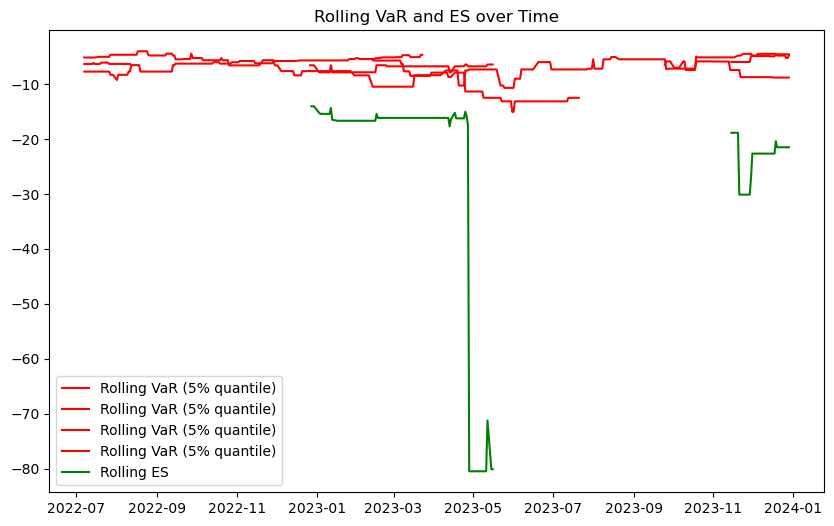

In [47]:
# 打印计算结果
print(f"滚动窗口计算的VaR：\n{rolling_VaR.tail()}")
print(f"滚动窗口计算的ES：\n{rolling_ES.tail()}")

# 可视化结果（如需要）
plt.figure(figsize=(10, 6))
plt.plot(rolling_VaR, label="Rolling VaR (5% quantile)", color='r')
plt.plot(rolling_ES, label="Rolling ES", color='g')
plt.legend()
plt.title("Rolling VaR and ES over Time")
plt.show()

In [58]:

def calculate_rolling_ES(returns, VaR):
    rolling_ES = pd.DataFrame(index=returns.index[window_size:], columns=returns.columns)
    for i in range(window_size, len(returns)):
        window_returns = returns.iloc[i-window_size:i]
        VaR_values = VaR.iloc[i]
        ES_values = {}
        for asset in returns.columns:
            # 获取当前资产的 VaR 值和对应的窗口收益率
            asset_VaR = VaR_values[asset]
            asset_returns = window_returns[asset]
            # 计算 ES
            ES_value = asset_returns[asset_returns <= asset_VaR].mean()
            ES_values[asset] = ES_value
        rolling_ES.iloc[i - window_size] = ES_values
    return rolling_ES


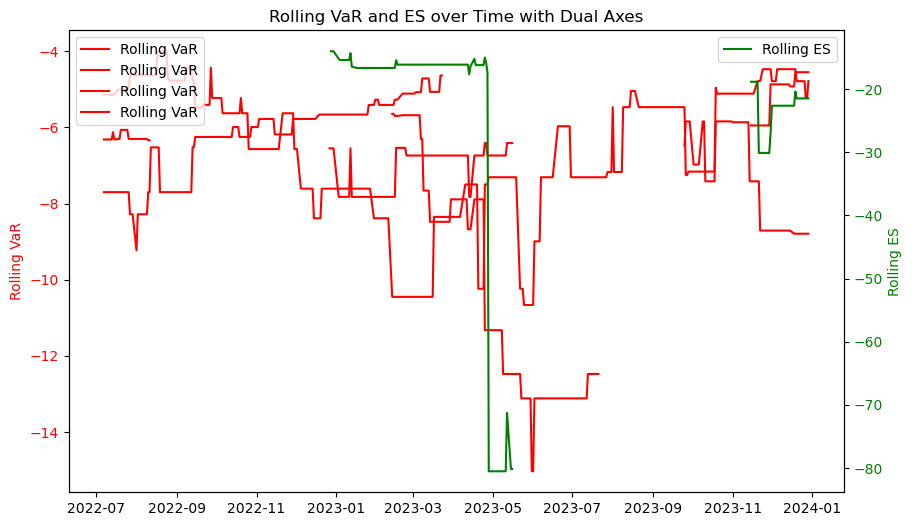

In [59]:
import matplotlib.pyplot as plt

# 假设 rolling_VaR 和 rolling_ES 是单列的 Series
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制 Rolling VaR 在左轴
ax1.plot(rolling_VaR, label="Rolling VaR", color='red')
ax1.set_ylabel('Rolling VaR', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left')

# 创建右轴，绘制 Rolling ES
ax2 = ax1.twinx()
ax2.plot(rolling_ES, label="Rolling ES", color='green')
ax2.set_ylabel('Rolling ES', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# 设置标题
plt.title("Rolling VaR and ES over Time with Dual Axes")
plt.show()



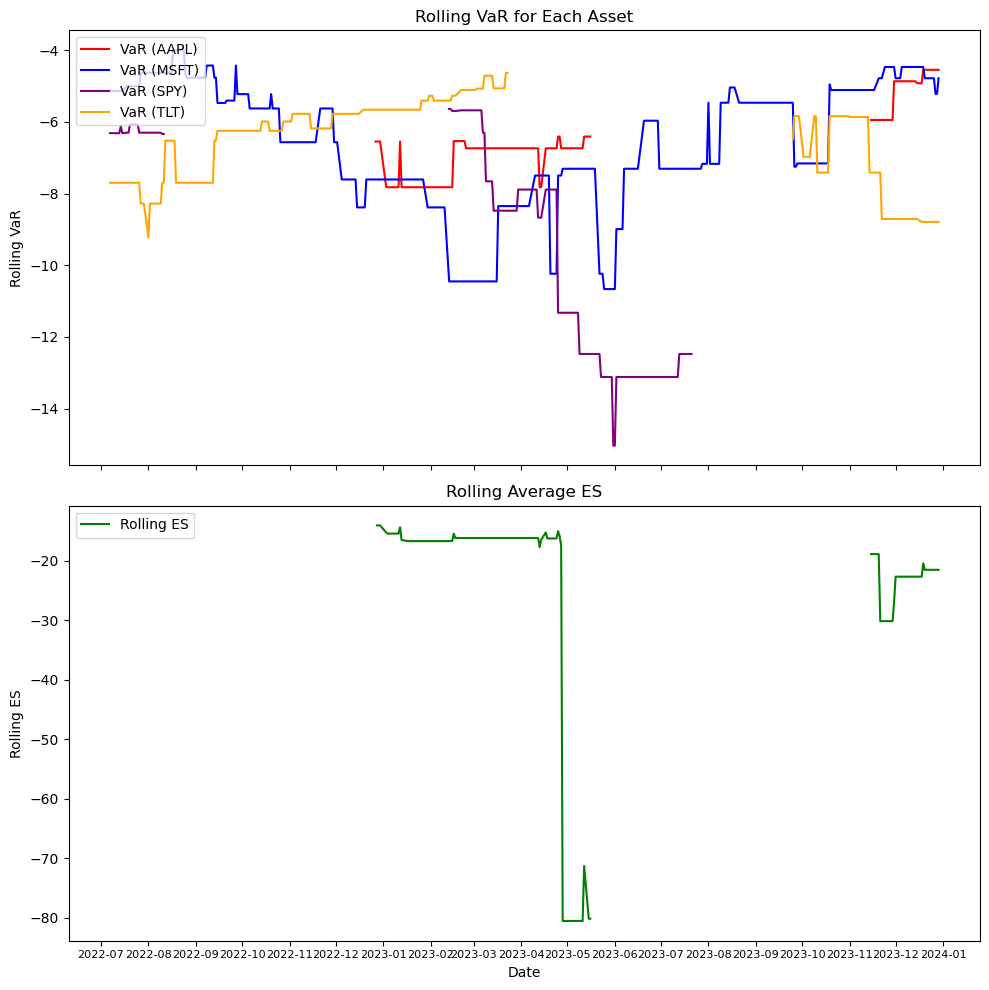

In [67]:
import matplotlib.dates as mdates

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# VaR 图（带有不同颜色）
colors = ['red', 'blue', 'purple', 'orange']  # 不同的颜色用于不同资产
for idx, column in enumerate(rolling_VaR.columns):
    ax1.plot(rolling_VaR.index, rolling_VaR[column], label=f"VaR ({column})", color=colors[idx % len(colors)])
ax1.set_ylabel("Rolling VaR")
ax1.legend(loc="upper left")
ax1.set_title("Rolling VaR for Each Asset")

# 在 ax1 和 ax2 上设置日期格式和字体大小
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.tick_params(axis='x', labelsize=8)

# ES 图
if isinstance(rolling_ES, pd.Series):
    ax2.plot(rolling_ES.index, rolling_ES, label="Rolling ES", color='green')
else:
    ax2.plot(rolling_ES.index, rolling_ES.mean(axis=1), label="Average Rolling ES", color='green')

ax2.set_ylabel("Rolling ES")
ax2.legend(loc="upper left")
ax2.set_title("Rolling Average ES")

# 再次在 ax2 上设置日期格式和字体大小
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.tick_params(axis='x', labelsize=8)


plt.xlabel("Date")
plt.tight_layout()
plt.show()




In [131]:
# 能自动更新的风控模型构建（随机模拟部分后续可以通过API接口替换）
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 假设你已经加载了历史数据
data = pd.read_csv("C:/Users/12/Desktop/financial_data_log.csv", index_col='Date', parse_dates=True)

# 检查是否有零值
zero_values = (data == 0).sum()
print("Initial zero values count per asset:\n", zero_values)

# 选择性处理零值
# 方法1：用相邻非零值的平均值替换零值
data = data.replace(0, np.nan)  # 先将零值替换为 NaN
data = data.interpolate(method='linear', limit_direction='both')  # 线性插值

# 再次检查零值
zero_values_after = (data == 0).sum()
print("Zero values count after interpolation:\n", zero_values_after)

# 显示清洗后的数据
print("Data after zero-value processing:\n", data.head())
# 模拟生成最新的市场数据

def get_latest_data(num_samples=500):
    dates = pd.date_range(end=pd.Timestamp.today(), periods=num_samples, freq='B')  # B for business days
    new_data = pd.DataFrame({
        'AAPL': np.random.normal(0, 0.02, num_samples),
        'MSFT': np.random.normal(0, 0.02, num_samples),
        'SPY': np.random.normal(0, 0.02, num_samples),
        'TLT': np.random.normal(0, 0.02, num_samples)
    }, index=dates)
    return new_data

# 生成并查看数据
new_data = get_latest_data(500)
print(new_data.head())


Initial zero values count per asset:
 AAPL    2
MSFT    0
SPY     2
TLT     1
dtype: int64
Zero values count after interpolation:
 AAPL    0
MSFT    0
SPY     0
TLT     0
dtype: int64
Data after zero-value processing:
                                AAPL      MSFT       SPY       TLT
Date                                                             
2022-01-04 00:00:00+00:00 -0.012773 -0.017296 -0.000335 -0.004167
2022-01-05 00:00:00+00:00 -0.026960 -0.039144 -0.019389 -0.005443
2022-01-06 00:00:00+00:00 -0.016834 -0.007933 -0.000940  0.002585
2022-01-07 00:00:00+00:00  0.000988  0.000509 -0.003961 -0.007214
2022-01-10 00:00:00+00:00  0.000116  0.000732 -0.001245  0.002457
                                AAPL      MSFT       SPY       TLT
2022-12-13 13:41:10.563636 -0.003076  0.013909 -0.008690 -0.025426
2022-12-14 13:41:10.563636 -0.017705  0.022577  0.006605  0.021172
2022-12-15 13:41:10.563636 -0.005496  0.014774 -0.014801  0.004295
2022-12-16 13:41:10.563636  0.000732  0.017308  0.0

In [132]:
# 更新 VaR 和 ES 计算的函数
def update_risk_measures(data, window_size=120):
    returns = data.pct_change().dropna()

     # 填补 returns 数据中的空缺值
    returns = returns.fillna(method='ffill').fillna(method='bfill')
    
    # 重新计算滚动 VaR 和 ES
    rolling_VaR = returns.rolling(window=window_size).quantile(0.05)
    rolling_ES = returns[returns <= rolling_VaR].mean()
    
    # 移除 NaN 值
    rolling_VaR = rolling_VaR.dropna(how='all')
    rolling_ES = rolling_ES.dropna()
    # 填充 NaN 值
    rolling_VaR['SPY'].fillna(0, inplace=True)  # 或用 rolling_VaR['SPY'].fillna(rolling_VaR['SPY'].mean(), inplace=True)
    rolling_VaR['TLT'].fillna(0, inplace=True)
    
    return rolling_VaR, rolling_ES


In [124]:
#调试部分（或许可以删掉）
# 更新 VaR 和 ES 计算的函数
def update_risk_measures(data, window_size=30):
    returns = data.pct_change().dropna()
    print("Returns (after pct_change):\n", returns.tail())  # 检查 returns 的输出
    
    # 重新计算滚动 VaR 和 ES
    rolling_VaR = returns.rolling(window=window_size).quantile(0.05)
    print("Rolling VaR (before dropping NaN):\n", rolling_VaR.tail())  # 检查 rolling_VaR 的输出

    rolling_ES = returns[returns <= rolling_VaR].mean()
    print("Rolling ES (before dropping NaN):\n", rolling_ES)  # 检查 rolling_ES 的输出
    
    # 移除 NaN 值
    rolling_VaR = rolling_VaR.dropna(how='all')
    rolling_ES = rolling_ES.dropna()
    
    print("Final Rolling VaR:\n", rolling_VaR.tail())  # 检查最终的 rolling_VaR
    print("Final Rolling ES:\n", rolling_ES)           # 检查最终的 rolling_ES
    
    return rolling_VaR, rolling_ES


In [112]:
#调试部分
rolling_VaR, rolling_ES = update_risk_measures(data)


Returns (after pct_change):
                                 AAPL        MSFT       SPY       TLT
2024-11-10 19:20:29.842602  0.033666   -0.993800  3.430997  4.018457
2024-11-10 19:26:57.481075 -1.088145  150.192571 -2.876350  1.180042
2024-11-10 19:35:35.342510  0.693899   -0.825736 -1.264520  0.149278
2024-11-10 19:36:28.992520 -1.623027   -2.265439 -2.465382 -0.459631
2024-11-10 19:36:40.056843  3.627810    1.264403 -3.194920  0.158910
Rolling VaR (before dropping NaN):
                                 AAPL      MSFT       SPY       TLT
2024-11-10 19:20:29.842602 -4.505341 -7.594125 -5.602829 -7.363389
2024-11-10 19:26:57.481075 -4.505341 -7.594125 -5.602829 -5.443577
2024-11-10 19:35:35.342510 -4.505341 -7.594125 -5.602829 -4.904706
2024-11-10 19:36:28.992520 -4.505341 -7.594125 -5.602829 -4.904706
2024-11-10 19:36:40.056843 -4.082803 -7.594125 -5.602829 -4.904706
Rolling ES (before dropping NaN):
 AAPL   -29.692426
MSFT   -14.122583
SPY    -14.466627
TLT    -14.264725
dtype: float

In [133]:
# 获取并合并新数据
new_data = get_latest_data()  # 使用随机生成的模拟数据
data = pd.concat([data, new_data])

# 计算 SPY 的滚动 VaR，单独检查 SPY 列的 VaR 计算是否正常
spy_rolling_VaR = returns['SPY'].rolling(window=30).quantile(0.05)
print("SPY Rolling VaR:\n", spy_rolling_VaR.tail())

# 更新 VaR 和 ES
rolling_VaR, rolling_ES = update_risk_measures(data)

# 打印结果
print("Updated Rolling VaR:\n", rolling_VaR.tail())
print("Updated Rolling ES:\n", rolling_ES.tail())



SPY Rolling VaR:
 2024-11-04 20:00:05.986895    -5.486658
2024-11-05 20:00:05.986895    -5.486658
2024-11-06 20:00:05.986895    -4.129355
2024-11-07 20:00:05.986895    -4.129355
2024-11-08 20:00:05.986895   -22.396056
Name: SPY, dtype: float64
Updated Rolling VaR:
                                 AAPL      MSFT       SPY       TLT
2024-11-05 13:41:34.872599 -4.455318 -5.695044 -4.455282 -5.235329
2024-11-06 13:41:34.872599 -4.455318 -5.695044 -4.455282 -5.235329
2024-11-07 13:41:34.872599 -4.455318 -5.695044 -4.455282 -5.235329
2024-11-08 13:41:34.872599 -4.455318 -5.695044 -4.455282 -5.016807
2024-11-11 13:41:34.872599 -4.455318 -5.695044 -4.455282 -5.016807
Updated Rolling ES:
 AAPL   -33.478572
MSFT   -20.855944
SPY    -19.610998
TLT    -21.687279
dtype: float64


C:\Users\12\AppData\Local\Temp\ipykernel_16020\3683583666.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = returns.fillna(method='ffill').fillna(method='bfill')
C:\Users\12\AppData\Local\Temp\ipykernel_16020\3683583666.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rolling_VaR['SPY'].fillna(0, inplace=True)  # 或用 rolling_VaR['SPY'].fillna(rolling_VaR['SPY'].mean(), inplace=True)
C:\Users\12\AppData\Local\Temp\ipykerne

In [126]:
print("Non-NaN counts in SPY column:\n", returns['SPY'].notna().sum())


Non-NaN counts in SPY column:
 499


In [127]:
spy_rolling_VaR = returns['SPY'].rolling(window=30).quantile(0.05)
print("SPY Rolling VaR with smaller window:\n", spy_rolling_VaR.tail())


SPY Rolling VaR with smaller window:
 Date
2023-12-22 00:00:00+00:00   -5.602829
2023-12-26 00:00:00+00:00   -5.602829
2023-12-27 00:00:00+00:00   -5.602829
2023-12-28 00:00:00+00:00   -4.190874
2023-12-29 00:00:00+00:00   -5.602829
Name: SPY, dtype: float64


In [128]:
# 更新 VaR 和 ES 计算的函数，临时将 window_size 修改为 50 进行调试
def update_risk_measures(data, window_size=30):  # 这里将126改为50
    returns = data.pct_change().dropna()

    # 重新计算滚动 VaR 和 ES
    rolling_VaR = returns.rolling(window=window_size).quantile(0.05)
    rolling_ES = returns[returns <= rolling_VaR].mean()
    
    # 移除 NaN 值
    rolling_VaR = rolling_VaR.dropna(how='all')
    rolling_ES = rolling_ES.dropna()
    
    return rolling_VaR, rolling_ES

# 单独计算 SPY 的滚动 VaR，窗口大小也改为 50
spy_rolling_VaR = returns['SPY'].rolling(window=30).quantile(0.05)
print("SPY Rolling VaR with window 50:\n", spy_rolling_VaR.tail())

# 获取并合并新数据
new_data = get_latest_data()  # 使用随机生成的模拟数据
data = pd.concat([data, new_data])

# 更新 VaR 和 ES
rolling_VaR, rolling_ES = update_risk_measures(data)

# 打印结果
print("Updated Rolling VaR:\n", rolling_VaR.tail())
print("Updated Rolling ES:\n", rolling_ES.tail())


SPY Rolling VaR with window 50:
 Date
2023-12-22 00:00:00+00:00   -5.602829
2023-12-26 00:00:00+00:00   -5.602829
2023-12-27 00:00:00+00:00   -5.602829
2023-12-28 00:00:00+00:00   -4.190874
2023-12-29 00:00:00+00:00   -5.602829
Name: SPY, dtype: float64
Updated Rolling VaR:
                                 AAPL      MSFT        SPY       TLT
2024-11-04 20:00:05.986895 -3.455212 -5.178675  -5.486658 -9.238601
2024-11-05 20:00:05.986895 -3.455212 -5.178675  -5.486658 -9.238601
2024-11-06 20:00:05.986895 -3.455212 -5.178675  -4.129355 -9.368903
2024-11-07 20:00:05.986895 -3.455212 -5.178675  -4.129355 -8.884775
2024-11-08 20:00:05.986895 -3.455212 -5.178675 -22.396056 -8.884775
Updated Rolling ES:
 AAPL   -57.709114
MSFT   -23.116292
SPY    -20.493877
TLT    -27.551968
dtype: float64


In [129]:

# 保存 VaR 和 ES 结果到 CSV 文件
rolling_VaR.to_csv("C:/Users/12/Desktop/updated_VaR.csv")
rolling_ES.to_csv("C:/Users/12/Desktop/updated_ES.csv")

PermissionError: [Errno 13] Permission denied: 'C:/Users/12/Desktop/updated_VaR.csv'

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-18 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-22 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-23 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-24 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-25 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-30 00:00:00+0000', tz='UTC'),
       Timestamp('2022-03-31 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-01 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-04 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-05 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-06 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-07 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-08 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-11 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-12 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-14 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-18 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-19 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-20 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-22 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-25 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-26 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-27 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-04-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-02 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-03 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-04 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-05 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-06 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-09 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-10 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-11 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-12 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-16 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-17 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-18 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-19 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-20 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-23 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-24 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-25 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-26 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-27 00:00:00+0000', tz='UTC'),
       Timestamp('2022-05-31 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-01 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-02 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-03 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-06 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-07 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-08 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-09 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-10 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-14 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-15 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-16 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-17 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-22 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-23 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-24 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-27 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-06-30 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-01 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-05 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-06 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-07 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-08 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-11 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-12 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-14 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-15 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-18 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-19 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-20 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-22 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-25 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-26 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-27 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-07-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-01 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-02 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-03 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-04 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-05 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-08 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-09 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-10 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-11 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-12 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-15 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-16 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-17 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-18 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-19 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-22 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-23 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-24 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-25 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-26 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-30 00:00:00+0000', tz='UTC'),
       Timestamp('2022-08-31 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-01 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-02 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-06 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-07 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-08 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-09 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-12 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-14 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-15 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-16 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-19 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-20 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-22 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-23 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-26 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-27 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-09-30 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-03 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-04 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-05 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-06 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-07 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-10 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-11 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-12 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-14 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-17 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-18 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-19 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-20 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-24 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-25 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-26 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-27 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-01 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-02 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-03 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-04 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-07 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-08 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-09 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-10 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-11 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-14 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-15 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-16 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-17 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-18 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-22 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-23 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-25 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-11-30 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-01 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-02 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-05 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-06 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-07 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-08 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-09 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-12 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-14 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-15 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-16 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-19 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-20 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-22 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-23 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-27 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-12-30 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-03 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-04 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-05 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-09 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-10 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-11 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-12 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-17 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-18 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-19 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-20 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-23 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-24 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-25 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-26 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-30 00:00:00+0000', tz='UTC'),
       Timestamp('2023-01-31 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-01 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-02 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-03 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-07 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-08 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-09 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-10 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-14 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-15 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-16 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-17 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-21 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-22 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-23 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-24 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-02-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-01 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-02 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-03 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-07 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-08 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-09 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-10 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-14 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-15 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-16 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-17 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-20 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-21 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-22 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-23 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-24 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-29 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-30 00:00:00+0000', tz='UTC'),
       Timestamp('2023-03-31 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-03 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-04 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-05 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-10 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-11 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-12 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-14 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-17 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-18 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-19 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-20 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-21 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-24 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-25 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-26 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-04-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-01 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-02 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-03 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-04 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-05 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-08 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-09 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-10 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-11 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-12 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-15 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-16 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-17 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-18 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-19 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-22 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-23 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-24 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-25 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-26 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-30 00:00:00+0000', tz='UTC'),
       Timestamp('2023-05-31 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-01 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-02 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-05 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-07 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-08 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-09 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-12 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-14 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-15 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-16 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-20 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-21 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-22 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-23 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-26 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-29 00:00:00+0000', tz='UTC'),
       Timestamp('2023-06-30 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-03 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-05 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-07 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-10 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-11 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-12 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-14 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-17 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-18 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-19 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-20 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-21 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-24 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-25 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-26 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-07-31 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-01 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-02 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-03 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-04 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-07 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-08 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-09 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-10 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-11 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-14 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-15 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-16 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-17 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-18 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-21 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-22 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-23 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-24 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-25 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-29 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-30 00:00:00+0000', tz='UTC'),
       Timestamp('2023-08-31 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-01 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-05 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-07 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-08 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-11 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-12 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-14 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-15 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-18 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-19 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-20 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-21 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-22 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-25 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-26 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-09-29 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-02 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-03 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-04 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-05 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-09 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-10 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-11 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-12 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-16 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-17 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-18 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-19 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-20 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-23 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-24 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-25 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-26 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-30 00:00:00+0000', tz='UTC'),
       Timestamp('2023-10-31 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-01 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-02 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-03 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-07 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-08 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-09 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-10 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-14 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-15 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-16 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-17 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-20 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-21 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-22 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-24 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-29 00:00:00+0000', tz='UTC'),
       Timestamp('2023-11-30 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-01 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-04 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-05 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-06 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-07 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-08 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-11 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-12 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-13 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-14 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-15 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-18 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-19 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-20 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-21 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-22 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-26 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-27 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-28 00:00:00+0000', tz='UTC'),
       Timestamp('2023-12-29 00:00:00+0000', tz='UTC'),
       Timestamp('2024-11-10 18:29:52.856243'),
       Timestamp('2024-11-10 18:32:46.506184'),
       Timestamp('2024-11-10 18:34:41.899945'),
       Timestamp('2024-11-10 19:20:29.842602'),
       Timestamp('2024-11-10 19:26:57.481075')], dtype=object)

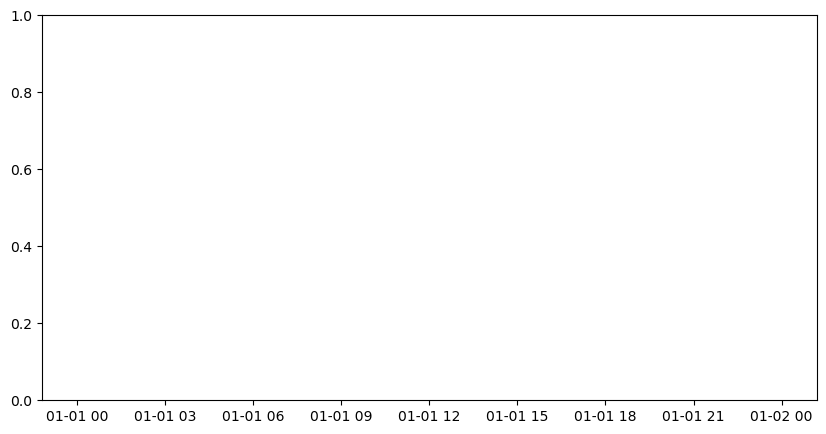

In [100]:
# 绘制图表
fig, ax1 = plt.subplots(figsize=(10, 5))

colors = ['red', 'blue', 'purple', 'orange']
for idx, column in enumerate(rolling_VaR.columns):
    ax1.plot(rolling_VaR.index, rolling_VaR[column], label=f"VaR ({column})", color=colors[idx % len(colors)])

ax1.set_ylabel("Rolling VaR")
ax1.legend(loc="upper left")
ax1.set_title("Rolling VaR for Each Asset")

# 设置日期格式和刻度
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.tick_params(axis='x', labelsize=8)

plt.xlabel("Date")
plt.tight_layout()
plt.show()
